In [56]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (roc_auc_score, average_precision_score,
                           roc_curve, precision_recall_curve,
                           confusion_matrix, classification_report)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import anndata as ad
ppmi_ad = ad.read_h5ad("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/ppmi_adata.h5ad")

In [ ]:
import pandas as pd
consensus_genes = pd.read_csv("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/feature_selection_consensus_males_30-50.csv", index_col=0)

In [ ]:
mask = ((ppmi_ad.obs['Age_Group'] == '30-50') &
        (ppmi_ad.obs['Gender'] == 'Male') &
        (ppmi_ad.obs['Diagnosis'].isin(['PD', 'Control'])) &
        (ppmi_ad.obs['Visit'] == 'BL'))

In [ ]:
ppmi_ad = ppmi_ad[mask]

In [ ]:
ppmi_ad = ppmi_ad[:, ppmi_ad.var.index.isin(consensus_genes.index)]

In [ ]:
X = pd.DataFrame(ppmi_ad.layers['counts_log2'], columns=ppmi_ad.var_names)
y = (ppmi_ad.obs['Diagnosis'] == 'PD').astype(int)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [58]:
rf_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(
        n_estimators=500,
        max_depth=8,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

In [59]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'rf__n_estimators': [100, 300, 500],
    'rf__max_depth': [5, 8, None],
    'rf__max_features': ['sqrt', 0.5],
    'smote__k_neighbors': [3, 5]
}

In [60]:
grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=StratifiedKFold(3),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

In [61]:
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [62]:
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:,1]

In [63]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.25      0.29         4
           1       0.57      0.67      0.62         6

    accuracy                           0.50        10
   macro avg       0.45      0.46      0.45        10
weighted avg       0.48      0.50      0.48        10



In [64]:
print(f"\nROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"PR-AUC: {average_precision_score(y_test, y_proba):.3f}")


ROC-AUC: 0.625
PR-AUC: 0.815


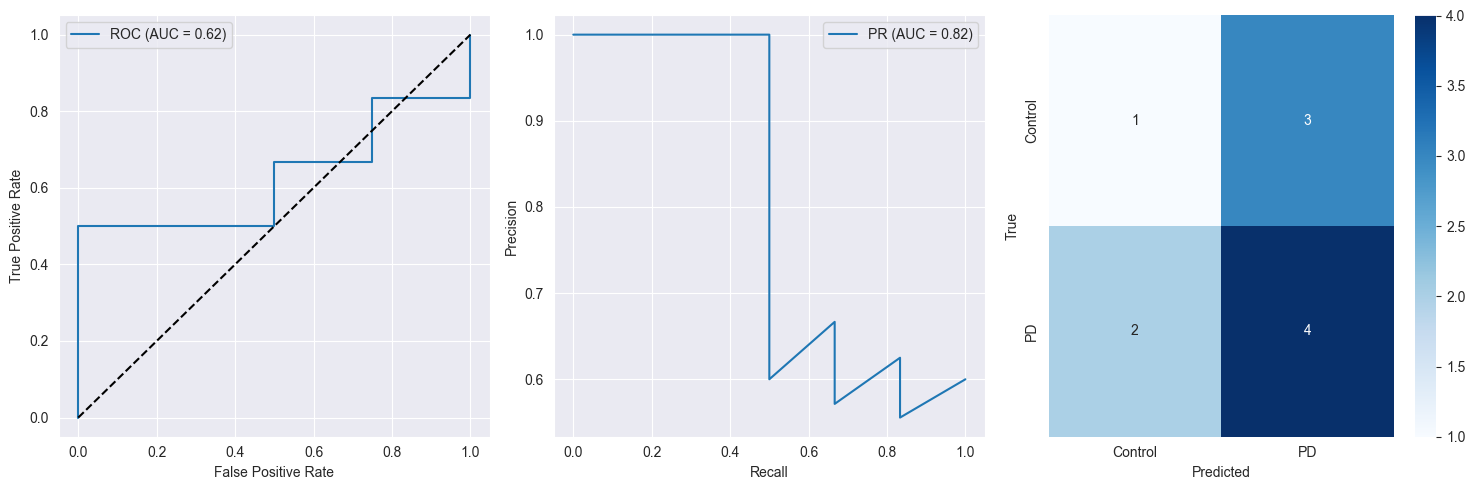

In [65]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot(1, 3, 2)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, label=f'PR (AUC = {average_precision_score(y_test, y_proba):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 3, 3)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Control', 'PD'],
            yticklabels=['Control', 'PD'])
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

In [66]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {'roc_auc': [], 'pr_auc': []}

for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    rf_pipeline.fit(X_train, y_train)
    y_proba = rf_pipeline.predict_proba(X_val)[:, 1]

    cv_scores['roc_auc'].append(roc_auc_score(y_val, y_proba))
    cv_scores['pr_auc'].append(average_precision_score(y_val, y_proba))

print("\nCross-validation results:")
print(f"ROC-AUC: {np.mean(cv_scores['roc_auc']):.3f} ± {np.std(cv_scores['roc_auc']):.3f}")
print(f"PR-AUC: {np.mean(cv_scores['pr_auc']):.3f} ± {np.std(cv_scores['pr_auc']):.3f}")


Cross-validation results:
ROC-AUC: 0.835 ± 0.141
PR-AUC: 0.898 ± 0.085


In [71]:
rf = rf_pipeline.named_steps['rf']
importances = pd.DataFrame({
    'ensembl_id': consensus_genes.index,
    'gene_symbol': consensus_genes['gene_symbol'],
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 important genes:")
print(importances.head(40)[['gene_symbol', 'importance']])


Top 20 important genes:
                        gene_symbol  importance
ENSG00000243415.2   ENSG00000243415    0.014778
ENSG00000213731.2           RAB5CP1    0.013306
ENSG00000230352.1   ENSG00000230352    0.010157
ENSG00000122644.12            ARL4A    0.010028
ENSG00000254279.1        IGHVII-1-1    0.009136
ENSG00000222232.1          RNA5SP89    0.008515
ENSG00000263443.1   ENSG00000263443    0.008455
ENSG00000229749.1           COTL1P1    0.007173
ENSG00000149443.7        SCP2D1-AS1    0.006813
ENSG00000248968.1   ENSG00000248968    0.006475
ENSG00000207403.1             Y_RNA    0.006372
ENSG00000232537.1   ENSG00000232537    0.006138
ENSG00000277636.1           MIR8061    0.006136
ENSG00000252008.1         RNU6-927P    0.005841
ENSG00000257955.1   ENSG00000257955    0.005797
ENSG00000257677.1         LINC02464    0.005580
ENSG00000200556.1         RNU6-103P    0.005557
ENSG00000211795.3           TRAV8-6    0.005473
ENSG00000225284.1   ENSG00000225284    0.005458
ENSG00000240973

/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_16452/4141259349.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


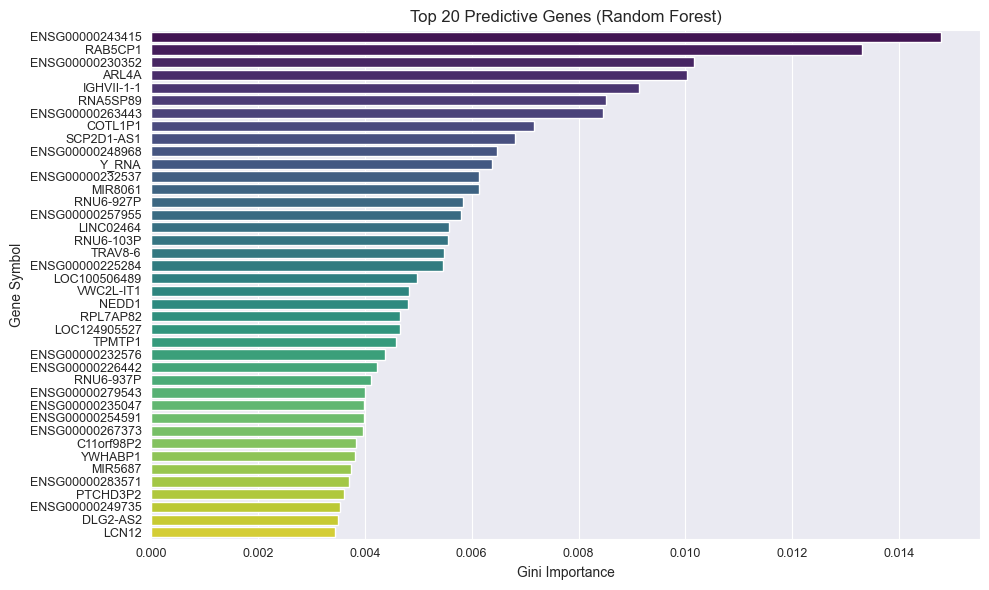

In [74]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=importances.head(40),
    x='importance',
    y='gene_symbol',
    palette='viridis'
)
plt.title('Top 20 Predictive Genes (Random Forest)')
plt.xlabel('Gini Importance')
plt.ylabel('Gene Symbol')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()